## Training Neural Network

The network built in the previous code is not trained. It cannot distinguish between digitis. Neural netwroks with non linear functions work like universal function approximators. There is some function which maps your input to the output. For example, images of handwritten digits to class probabilities. The power of Neural networks is that we can train them to approximate this function, and bascially any function given enough data and compute time. 

<img src ="function_approx.png">

At first the network is naive, it doesn't know  the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function. 

To find these parameters we need to understand how poorly the network is predicting the real outputs. For this we calculate the loss function(aka cost), a measure of our prediction error. The mean squared loss is often used in regression and binary classification problems as follows:

<img src ="mean_squared_cost.svg">

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels


The aim is to minimise this loss by tweaking the network parameters. We can find configuration where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. This minimum can be found using a process called gradient decent. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we want to follow the gradient(downwards). You can think of this like descending a mountain by following the steepest slope to the base. 

<img src = "gradient_descent.png">


## Backpropogation

For Single layer networks, gradient descent is straightforward to implement but is complicated for deeper multilayer networks. Training multilayer networks is done through backpropogation which is really an application of the chain rule from calculus. It's easy to understand if we convert a two layer network into graph representation as follows:

<img src ="backprop_diagram.png">

In forward pass through the network, our data and operations go from bottom to top in the above diagram. We pass the input $x$ through linear transformation $L1$ with weights $W1$ and biases $b1$. The output then goes through the sigmoid operations $S$ and another linear transformation $L2$. Finally we calculate the loss $l$. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

To train the weights with gradient descent, we propogate the gradient of the loss backwards through the network. Each operation has some gradient between the inputs and outputs. As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation. Mathematically, we are checking how the gradient of the loss is changing with resspect to the weights. This is done using the chain rule:

<img src = "chain_rule.svg">

We update the weights using this gradient with some learning rate  $\alpha$. as follows:

<img src ="learning_rate.svg">

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative methode settles at a minimum



## Losses in PyTorch

Through the nn module, PyTorch provides losses such as the corss-entropy loss (nn.CrossEntropyLoss). For a classification problem like MNIST we use the softmax function to predict the class probabilities. Hence we will be using cross-entropy as the loss function. 

Cross-Entropy : Measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of 0.012  when the actual observation label is 1, would be bad and result in a high loss value. A perfect model would have a log loss of 0. 

To calculate the loss, you first define the criterion and then pass in the output of your network and the correct labels. According to the documentation for the nn.CrossEntropyLoss, the criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class and the input is expected to contain scores for each class. 

This means we need to pass in the raw output of or network into the loss, not the output of the softmax function. This raw output is usually called the $logit$ or $scores$. We use logits because softmax gives you probabilities which will often be very close to zero or one. But floating-point numbers can't accurately represent values close to zero or one. Hence it is usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,)),])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle = True)

In [26]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.Softmax(dim=1))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0],-1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)


print(loss)

tensor(2.3029, grad_fn=<NllLossBackward>)


### Model that returns the log-softmax as the output and calculate the loss using negative log likeliood loss

In [27]:
# Building a feed forward network

model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))
# Define the loss
criterion = nn.NLLLoss()
#Get our data
images, labels = next(iter(trainloader))

# Flatten the images
images = images.view(images.shape[0],-1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate loss
loss = criterion(logps,labels)
print(loss)

tensor(2.3184, grad_fn=<NllLossBackward>)


## Autograd

Torch provides a module, autograd, for automatically calculating the gradients of the tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through these operations, calculating gradients along the way. To make sure PyTorch keeps track of the operations on a tensor and calculates the gradients, you need to set requires_grad = True on a tensor. You can do this at creation with the requires_grad keyword, or at any time with x.requires_grad_(True).

You can turn of gradients for a block of code with the torch.no_grad() content:
Also, you can turn on or off gradients altogether with torch.set_grad_enabled(True|False).

The gradients are computed with respect to some variable z with z.backward(). This does a backward pass through the operations that created z.

In [5]:
x = torch.randn(2,2, requires_grad = True)
print(x)

tensor([[ 0.7964, -0.9251],
        [ 0.1351,  0.9523]], requires_grad=True)


In [6]:
y = x**2
print(y)

tensor([[0.6343, 0.8558],
        [0.0183, 0.9068]], grad_fn=<PowBackward0>)


Below we can see the operation that created y, a power operation PowerBackward0

In [7]:
# grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of opeartions,  with respect to any one tensor. Let's reduce the tensor y to a scalar value, the mean

In [8]:
z = y.mean()
print(z)

tensor(0.6038, grad_fn=<MeanBackward0>)


You can check the gradients for x and y but they are empty currently.

In [9]:
print(x.grad)

None


To calculate the gradients, you need to run the .backward method on a Variable, z for example. This will calculate the gradient for z with respect to x

<img src ="gradient.svg">

In [10]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.3982, -0.4626],
        [ 0.0676,  0.4761]])
tensor([[ 0.3982, -0.4626],
        [ 0.0676,  0.4761]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step.

### Loss and Autograd

When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True. This means that when we calculate the loss and call loss.backward(), the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [77]:
# Buikd the network
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0],-1)

logps = model(images)
loss = criterion(logps, labels)
print(loss)

tensor(2.3316, grad_fn=<NllLossBackward>)


In [78]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[3.0718e-04, 3.0718e-04, 3.0718e-04,  ..., 3.0718e-04, 3.0718e-04,
         3.0718e-04],
        [1.7950e-03, 1.7950e-03, 1.7950e-03,  ..., 1.7950e-03, 1.7950e-03,
         1.7950e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.9399e-05, 7.9399e-05, 7.9399e-05,  ..., 7.9399e-05, 7.9399e-05,
         7.9399e-05],
        [2.6005e-03, 2.6005e-03, 2.6005e-03,  ..., 2.6005e-03, 2.6005e-03,
         2.6005e-03]])


###  Training the Network

For training, we need an optimizer to update the weights with the gradients. This can be done using the PyTorch's optim package. Below is an example of how stochastic gradient descent is defined using the package.

In [19]:
from torch import optim

#Optimizers require the parameters to optimize the lerning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Lets consider just one learning step before looping through all the data. The general process with PyTorch is as follows:
- Make a forward pass through the network
- Use the network output to calculate the loss
- Perform a backward pass through the network with loss.backward() to calculate the gradients
- Take a step with the optimizer to update the weights

Below i'll go through one training step and print out the weights and graients so you can see how it changes. Note that i have a line of code optimizer.zero_grad(). When you do multiple backwards passes with the same parameters, the gradients are accumalated. This means you need to zero the gradients before each pass or you'll retain gradients from previous training batches.

In [20]:
print("Initial Weights :", model[0].weight)

images,lables = next(iter(trainloader))
images.resize_(64,784)

# Clear the gradients, do this because gradients are accumalated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial Weights : Parameter containing:
tensor([[ 0.0155,  0.0337, -0.0024,  ..., -0.0091,  0.0057,  0.0348],
        [ 0.0076, -0.0269, -0.0076,  ..., -0.0010, -0.0083, -0.0353],
        [ 0.0201, -0.0120,  0.0255,  ...,  0.0211, -0.0098,  0.0003],
        ...,
        [-0.0295,  0.0004,  0.0092,  ..., -0.0286, -0.0206, -0.0068],
        [ 0.0185,  0.0134, -0.0194,  ..., -0.0300, -0.0073,  0.0343],
        [ 0.0219,  0.0351, -0.0252,  ..., -0.0314,  0.0052, -0.0201]],
       requires_grad=True)
Gradient - tensor([[-2.6142e-03, -2.6142e-03, -2.6142e-03,  ..., -2.6142e-03,
         -2.6142e-03, -2.6142e-03],
        [-3.7246e-05, -3.7246e-05, -3.7246e-05,  ..., -3.7246e-05,
         -3.7246e-05, -3.7246e-05],
        [ 1.2361e-03,  1.2361e-03,  1.2361e-03,  ...,  1.2361e-03,
          1.2361e-03,  1.2361e-03],
        ...,
        [-6.9825e-04, -6.9825e-04, -6.9825e-04,  ..., -6.9825e-04,
         -6.9825e-04, -6.9825e-04],
        [ 4.3856e-04,  4.3856e-04,  4.3856e-04,  ...,  4.3856e-

In [21]:
# Take an update step and  few new weights
optimizer.step()
print('Updated weights -', model[0].weight)

Updated weights - Parameter containing:
tensor([[ 0.0155,  0.0337, -0.0024,  ..., -0.0090,  0.0057,  0.0348],
        [ 0.0076, -0.0269, -0.0076,  ..., -0.0010, -0.0083, -0.0353],
        [ 0.0201, -0.0120,  0.0254,  ...,  0.0211, -0.0098,  0.0003],
        ...,
        [-0.0295,  0.0004,  0.0092,  ..., -0.0286, -0.0205, -0.0068],
        [ 0.0185,  0.0134, -0.0194,  ..., -0.0300, -0.0073,  0.0343],
        [ 0.0219,  0.0351, -0.0252,  ..., -0.0314,  0.0051, -0.0201]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire data set is called an $epoch$. So here we are going to loop over through the trainloader to get our training batches. For each atch we'll be doing a training pass where we calculate the loss, do a backward pass, and update the weights

In [23]:
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.005)

epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0],-1)
        
        # TODO: training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.5612182392240332
Training loss: 0.5647211776835832
Training loss: 0.4124975564605646
Training loss: 0.35884864250225806
Training loss: 0.3301449251581611


With the network trained we can check out its predictions

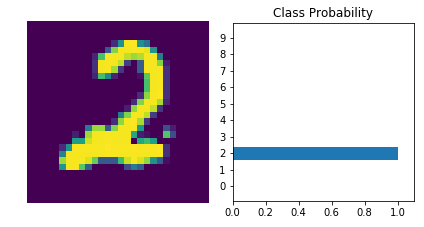

In [25]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1,784)

# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)
    

# Output  of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1,28,28), ps)

Now our network is brilliant. It can actually predict the digits in our images.